# Chapter 5. Recurrent Neural Network (RNN)

Word2vec 만으로는 자연어 처리가 원만하게 이루어질 수 없다! 

- CBOW (continuous bag-of-words)는 주변 단어를 순서에 무관하게 고려하여 학습하는 단어 분산 모델.
- Language model (언어 모델) : 단어의 시퀀스가 일어날 가능성이 어느 정도인지 확률로 평가.<br>
m개의 단어 시퀀스 $\{w_1, w_2, \cdots, w_m\}$에 대하여
\begin{equation}
P(w_1, w_2, \cdots, w_m) = \prod^{m}_{t=1}{P(w_t|w_1,\cdots,w_{t-1})} .
\end{equation}

- 위처럼, 단어의 시퀀스에 따라 확률이 정의되기 때문에, 이를 고려한 확률 모델을 형성할 필요가 있음.

## 1. RNN, 순환신경망

- 시계열 데이터 $(x_0, x_1, \cdots, x_t, \cdots)$ 를 학습하는 데 용이한 모델. ($t$ : 시간?)
- $x_t$ -> RNN layer -> $h_t$, $h_t$가 layer에 다시 들어가는 구조.
\begin{equation}
h_t = \tanh{(h_{t-1} W_h + x_t W_x + b)} .
\end{equation}

- 위 식과 같이, Input에 대응하는 weight $W_x$와 이전 output에 대응하는 $W_h$가 존재함.
- $h_t$는 다음 계층으로 넘어감과 동시에 다음 시각 $t+1$의 RNN 계층으로도 넘어간다.
- $h_{t-1}$ 상태에서 $h_t$로 갱신(업데이트)된다고 볼 수 있음. (Memory?)
- $h$ : hidden state, or hidden state vector. 

<hr>

### (1) BPTT (BackPropagation Through Time)

- BPTT : RNN의 경우, 시간에 따라 RNN 계층으로 이전 시간의 값이 들어오기 때문에, <br>
    이 흐름을 따라서도 역전파법으로 파라미터 (weight, bias)를 학습할 수 있다.  
- 하지만, 긴 시계열의 경우
    - 계산량이 너무 많아지게 되는 문제가 생긴다.
    - 역전파시의 기울기가 불안정해지는 문제가 생긴다. (Vanishing gradient, Overflowing, ...)

### (2) Truncated BPTT

- 다루기 힘든 큰 시계열의 경우 시간축으로 너무 길어진 신경망을 적당한 길이에서 잘라내어 역전파법을 수행.
- Example : $x_0$ ~ $x_9$, $x_10$ ~ $x_19$ 식으로 10개 단위로 끊어서 역전파 시행. (RNN이 10개 단위로 학습하게끔 함.)
    - cf 1) 순전파는 그대로 진행함에 유의할 것.
    - cf 2) 시계열 데이터 $(x_0, x_1, \cdots, x_t, \cdots)$ 는 시간 순서대로 입력되어야 함. 
      (mini-batch 학습은 무작위였음에 유의.)
- 위의 예시에 대한 학습 순서 : $x_0$ ~ $x_9$ 에 대해 순전파 및 역전파 시행 ->
    $h_9$를 입력받아, $x_{10}$ ~ $x_{19}$ 에 대해 순전파 및 역전파 시행. ($h_9$에 대한 기울기는 계산 X) -> ...
    
<hr>

### (3) Mini-batch 학습
- Mini-batch는 무작위로 뽑되, 연속된 데이터 셋을 뽑는다. 
(ex: 500번째 데이터부터 시작할 경우, ($x_{500}$, $x_{501}$, $\cdots$) ) 
- 각 batch 별로 데이터 제공 시작 위치를 옮겨줘야 함. (1번째가 $x_0$ -> $x_{10}$ 이면 2번째는 $x_{500}$ -> $x_{510}$.)

## 2. RNN 구현

$x_s = (x_0, x_1, \cdots, x_{T-1})$ 의 시계열 입력값들에 대한 출력 $h_s=(h_0,h_1,\cdots,h_{T-1})$과 같은 구조를
하나의 계층이라고 하자.

- $N$ : mini-batch size
- $D$ : Input dimension
- $H$ : layer neuron size
- $W_h$, $W_x$ : weight matrix ($h$와 $x$ 각각에 대한)
- $ \tanh{(h_{t-1} W_h + x_{t} W_x + b)} = h_t $ 에 대하여
    - $h_{t-1}$, $h_t$ : $N \times H$ matrix
    - $W_h$ : $H \times H$, square matrix (!!)
    - $W_x$ : $N \times D$
    - $b$ : $1 \times H$ 인데... 각 배치별로 더해주는 거니까, $N \times H$로 생각하자 (같은 행이 N개 나열된 구조). cf) Repeat 노드, 1.3.4 절 참고

In [1]:
# # 단일 RNN class : 이전 time의 값을 받아 1회 순전파 및 역전파를 하는 class.
# class RNN:
#     def __init__(self, Wx, Wh, b):
#         self.params = [Wx, Wh, b]
#         self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
#         self.cache = None
        
#     # Forward propagation
#     # h_prev, 전 시간대의 입력을 받는다.
#     def forward(self, x, h_prev):
#         Wx, Wh, b = self.params
#         t = np.matmul(x,Wx) + np.matmul(h_prev,Wh) + b
#         h_next = np.tanh(t)
        
#         self.cache = (x, h_prev, h_next)
#         return h_next
    
#     # backward propagation, 이후 시간대에 대한 기울기를 입력받음.
#     # Output : Input 및 h_prev에 대한 기울기를 반환 (이전 layers로 backpropagation을 위해 넘겨줌)
#     def backward(self, dh_next):
#         Wx, Wh, b = self.params
#         x, h_prev, h_next = self.cache
        
#         dt = dh_next * (1 - h_next ** 2) # tanh의 미분
#         db = np.sum(dt, axis=0)
#         dWh = np.matmul(h_prev.T, dt)
#         dh_prev = np.matmul(dt, Wh.T)
#         dWx = np.matmul(x.T, dt)
#         dx = np.matmul(dt, Wx.T)
        
#         self.grads[0][...] = dWx
#         self.grads[1][...] = dWh
#         self.grads[2][...] = db
        
#         return dx, dh_prev

In [2]:
# # TimeRNN 계층 구현
# # T개의 RNN 계층으로 구성됨. (T : 임의의 값. 예시에서는 10)
# # 다음 T개 sequence에 넘겨줄 (그리고 역전파에서 넘겨받을) 은닉 상태 h를 인스턴스 변수로 저장.

# class TimeRNN:
#     '''
#     parameters
    
#     stateful : 은닉상태 저장 여부. 
#         -True:  T번의 시간축 전파 후 은닉상태를 저장함.
#         -False : 은닉상태를 저장하지 않음. (h=0 초기화됨.)
    
#     '''
#     def __init__(self, Wx, Wh, b, stateful=False):
#         self.params = [Wx, Wh, b]
#         self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
#         # self.layers : 다수의 RNN Layer를 저장하기 위한 인스턴스 변수
#         self.layers = None
        
#         # Hidden state and its gradient
#         # Truncated BPTT이기에, 여기서 이전시간 역전파에 해당되는 dh는 쓰이지 않지만,
#         # 7장 seq2seq에 활용하기 위해 여기서는 일단 저장한다.
#         self.h, self.dh = None, None
#         self.stateful = stateful
        
#     def set_state(self, h):
#         self.h = h
        
#     def reset_state(self):
#         self.h = None
        
#     def forward(self, xs):
#         Wx, Wh, b = self.params
#         # N : mini-batch size
#         # T : Number of RNN layers.
#         # D : Input data vector dimension
#         # H : Number of hidden nodes
#         N, T, D = xs.shape
#         D, H = Wx.shape
        
#         self.layers = []
#         hs = np.empty((N, T, H), dtype='f')
        
#         # 처음 전파되는 경우 또는 stateful=False일 경우,
#         # h를 0으로 초기화.
#         if not self.stateful or self.h is None:
#             self.h = np.zeros((N,H), dtype='f')
            
#         for t in range(T):
#             layer = RNN(*self.params)
#             self.h = layer.forward(xs[:,t,:], self.h)
#             hs[:,t,:] = self.h
#             self.layers.append(layer)
            
#         return hs
    
#     def backward(self, dhs):
#         Wx, Wh, b = self.params
#         N, T, H = dhs.shape
#         D, H = Wx.shape
        
#         dxs = np.empty((N,T,D), dtype='f')
#         # Truncated BPTT이기에 미래계층에서 역전파한 기울기 dh는 0으로 초기화된다.
#         dh = 0
#         grads = [0,0,0]
        
#         # 시간에 역순으로 역전파가 이뤄짐에 주의.
#         for t in reversed(range(T)):
#             layer = self.layers[t]
#             dx, dh = layer.backward(dhs[:, t, :] + dh) # 미래 계층에서의 기울기와 위(뒤) 계층에서의 기울기가 합산되어 전파됨.
#             dxs[:, t, :] = dx
            
#             # 각 RNN 계층에서의 gradient 합산
#             for i, grad in enumerate(layer.grads):
#                 grads[i] += grad
            
#         for i, grad in enumerate(grads):
#             self.grads[i][...] = grad
#         self.dh = dh
        
#         return dxs
    

## 3. RNN Language Model (RNNLM)

가장 단순한(?) RNNLM의 신경망 구성 : <br>
input - Embedding - RNN - Affine - Softmax - output
- Embedding : 단어 ID를 단어 벡터로 변환 (word2vec 참고)
- RNN : RNN layer (위에 설명됨.)
- Affine : Fully-connected layer x*W + b 연산 처리
- Softmax : Softmax 함수로 처리.

- RNN에서의 hidden state는 이전 sequence의(=과거의) 정보를 '기억'하고 있다. ($h$의 형태로 저장)
- T개 씩 끊어서 학습이 되기 때문에, T개에 대한 Loss function의 평균이 계산된다.
- T개의 시계열 시퀀스를 처리하는 계층에 대해서는 'common/time_layers.py'를 참고.

In [3]:
# # Simple RNN Language Model 구현
# import sys
# sys.path.append('..')
# import numpy as np
# from common.time_layers import *

# class SimpleRnnlm:
#     '''
#     Embedding - RNN - Affine - Softmax - Loss
#     '''
#     def __init__(self, vocab_size, wordvec_size, hidden_size):
#         V, D, H = vocab_size, wordvec_size, hidden_size
#         rn = np.random.rand
        
#         # Xavier initialization
#         embed_W = (rn(V,D) / 100).astype('f')
#         rnn_Wx = (rn(D,H) / np.sqrt(D)).astype('f')
#         rnn_Wh = (rn(H,H) / np.sqrt(H)).astype('f')
#         rnn_b = np.zeros(H).astpye('f')
#         affine_W = (rn(H,V) / np.sqrt(H)).astype('f')
#         affine_b = np.zeros(V).astype('f')
        
#         self.layers = [
#             TimeEmbedding(embed_W),
#             TimeRNN(rnn_Wx, rnn_Wh,rnn_b,stateful=True)
#             TimeAffine(affine_W,affine_b)
#         ]
#         self.loss_layer = TimeSoftmasWithLoss()
#         self.rnn_layer = self.layers[1]
        
#         self.params, self.grads = [], []
#         for layer in layers:
#             self.params += layer.params
#             self.grads += layer.grads
            
#     def forward(self, xs, ts):
#         for layer in self.layers:
#             xs = layer.forward(xs)
#         loss = self.loss_layer.forward(xs,ts)
#         return loss
    
#     def backward(self, dout=1):
#         dout = self.loss_layer.backward(dout)
#         for layer in reversed(self.layers):
#             dout = layer.backward(dout)
#         return dout
    
#     def reset_state(self):
#         self.rnn_layer.reset_state()

In [4]:
# RNNLM 학습
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD, Adam
from dataset import ptb
from simple_rnnlm import SimpleRnnlm

# hyperparameters
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN hidden nodes
time_size = 5
lr = 0.1
max_epoch = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus)+1)

xs = corpus[:-1] # input
ts = corpus[1:] # output
data_size = len(xs)
print('corpus_size: %d, vocab_size: %d' % (corpus_size, vocab_size))

max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 각 미니배치에서 샘플을 읽기 시작할 위치를 계산.
# batch_size 단위로 
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        batch_x = np.empty((batch_size,time_size), dtype='i')
        batch_t = np.empty((batch_size,time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1
            
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
        
    ppl = np.exp(total_loss / loss_count)
    print('| epoch %d | perplexity %.2f' %(epoch+1,ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

corpus_size: 1000, vocab_size: 418
| epoch 1 | perplexity 406.74
| epoch 2 | perplexity 304.50
| epoch 3 | perplexity 231.41
| epoch 4 | perplexity 218.40
| epoch 5 | perplexity 207.13
| epoch 6 | perplexity 203.55
| epoch 7 | perplexity 200.02
| epoch 8 | perplexity 196.99
| epoch 9 | perplexity 191.33
| epoch 10 | perplexity 191.86
| epoch 11 | perplexity 187.94
| epoch 12 | perplexity 192.01
| epoch 13 | perplexity 189.78
| epoch 14 | perplexity 190.46
| epoch 15 | perplexity 188.65
| epoch 16 | perplexity 184.75
| epoch 17 | perplexity 182.64
| epoch 18 | perplexity 179.38
| epoch 19 | perplexity 182.52
| epoch 20 | perplexity 184.55
| epoch 21 | perplexity 180.43
| epoch 22 | perplexity 176.36
| epoch 23 | perplexity 172.82
| epoch 24 | perplexity 175.35
| epoch 25 | perplexity 173.46
| epoch 26 | perplexity 170.54
| epoch 27 | perplexity 170.90
| epoch 28 | perplexity 166.39
| epoch 29 | perplexity 167.14
| epoch 30 | perplexity 158.65
| epoch 31 | perplexity 161.89
| epoch 32 | 

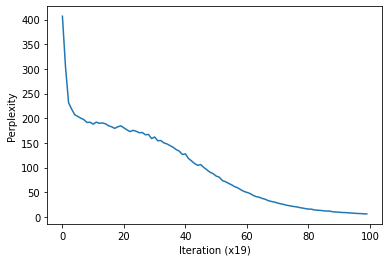

In [10]:
x = np.arange(len(ppl_list))

plt.plot(x, ppl_list, label='train')
plt.xlabel('Iteration (x' + str(max_iters) + ')')
plt.ylabel('Perplexity')
plt.show()


Note : 위의 훈련 및 그림 코드는 train.py 파일과 동일함.
단, RnnlmTrainer class를 사용했는데, 자세한 것은 common/trainer.py 코드 참고.